In [1]:
import numpy as np
import matplotlib.pyplot as plt

import GPy
import bayesoptlib as BO

from casadi import *
import plant_simulator as mdl

In [2]:
par = mdl.EnterpriseA_parameters()
sys,simulator = mdl.EnterpriseA(par,Ts = 1)

#save_plots = True
chgSeed = 0

CasADi - 2025-04-04 19:40:18 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:521]


In [3]:
def WilliamsOtto(simT=3600,xf = [0,1,0,0,0,0,293],Fb=0.2,Fa=1.3):
    p_in = [Fb,Fa]
    xa = []
    xb = []
    xp = []
    xe = []
    xg = []
    Tr = []
    l = []
    for sim_k in range(simT):
        Fk = simulator(x0=xf,p=p_in)
        xf = Fk['xf']
        qf = Fk['qf']
        xa.append(xf.full()[0])
        xb.append(xf.full()[1])
        xp.append(xf.full()[3])
        xe.append(xf.full()[4])
        xg.append(xf.full()[5])
        Tr.append(xf.full()[6])
        l.append(qf.full()+ np.random.normal(0,0.15))

    xa = np.array(xa).reshape(-1,1)
    xb = np.array(xb).reshape(-1,1)
    xp = np.array(xp).reshape(-1,1)
    xe = np.array(xe).reshape(-1,1)
    xg = np.array(xg).reshape(-1,1)
    Tr = np.array(Tr).reshape(-1,1)
    l = np.array(l).reshape(-1,1)

    f0 = qf.full() +np.random.normal(0,0.15)
    f1 = (0.12- xf.full()[0])*1000

    return f0,f1,xf.full(),xa,xb,xp,xe,xg,Tr,l


In [4]:
def SSD(y,n=10,Rc=1):
    x = y[-1-n:-1]
    X = np.sum(x)/n
    s = 0
    for i in range(n):
        s = s + (x[i] - X)**2
    s = s/(n-1)

    sd = 0
    for i in range(n-1):
        sd = sd + (x[i+1] - x[i])**2
    sd = sd/(n-1)
    R = sd/s
    if R >Rc:
        SS = 1
    else:
        SS = 0
    return SS,R
    

time 0s: New setpoint updated by safe BO.
time 5100s: New setpoint updated by safe BO.
time 8100s: New setpoint updated by safe BO.
time 10200s: New setpoint updated by safe BO.
time 14400s: New setpoint updated by safe BO.
time 16800s: New setpoint updated by safe BO.
time 19800s: New setpoint updated by safe BO.
time 21900s: New setpoint updated by safe BO.
time 22200s: New setpoint updated by safe BO.
time 22500s: New setpoint updated by safe BO.
time 22800s: New setpoint updated by safe BO.
time 23100s: New setpoint updated by safe BO.
time 23400s: New setpoint updated by safe BO.
time 24300s: New setpoint updated by safe BO.
time 24600s: New setpoint updated by safe BO.
time 27000s: New setpoint updated by safe BO.
time 27300s: New setpoint updated by safe BO.
time 27600s: New setpoint updated by safe BO.
time 27900s: New setpoint updated by safe BO.
time 28200s: New setpoint updated by safe BO.
time 28500s: New setpoint updated by safe BO.
time 29400s: New setpoint updated by saf

Text(0.5, 36.72222222222221, 'Time [h]')

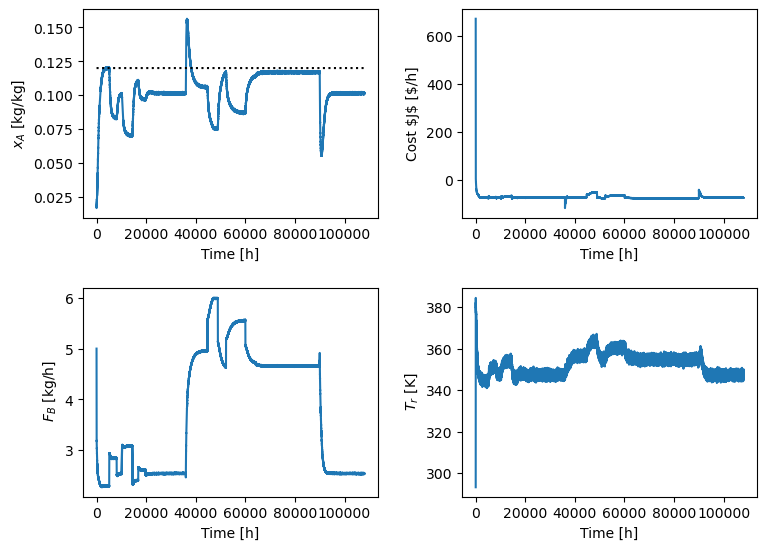

In [5]:
simT = 1
Fb = 5
Fa = 1

f0,f1,xf,xa,xb,xp,xe,xg,Tr,l = WilliamsOtto(simT = simT,Fb=Fb,Fa=Fa)
f0,f1,xf,xa,_,_,_,_,_,_= WilliamsOtto(simT = 3600,Fb=Fb,Fa=Fa)
xa = xa[-1]
X_sample = np.array(xa).reshape(-1,1)
XD_sample = np.concatenate((X_sample.reshape(-1,1),np.array(Fa).reshape(-1,1)),axis=1)
Y1_sample = f0.reshape(1,1) # Cost
Y2_sample = f1.reshape(1,1) # Constraint

J = [f0]
xA = [xa]
xB = [xb]
xP = [xp]
xE = [xe]
xG = [xg]
u = [Fb]
T = [Tr]
L = [l]
Fbmax = Fb
err0 = 0

ss = 0
BO_flag = 0
SS_flag = []
inputDim = 2 

var0 = 100
kernel_f = GPy.kern.RBF(inputDim,ARD = True, lengthscale=[0.02,0.05],variance=var0) + GPy.kern.Bias(inputDim) 
bounds = np.array([[0.07,0.12]]) # bounds for Fb

U_range = np.linspace(bounds[:, 0].T, bounds[:, 1].T, 1000).reshape(1000,-1)

nHours = 30*3600
count = 0
for i in range(nHours-1):
    if i>=10*3600:
        Fa = 1.9
    if i>=25*3600:
        Fa = 1

    if  i ==0 or i%300 ==0 and ss==1 or i ==10*3600:
        BO_flag = 0
        print('time '+str(i)+'s: New setpoint updated by safe BO.')
        Context = np.array(Fa).reshape(-1,1)
        J_Obj = BO.contextual_bayesian_optimization(XD_sample,Y1_sample,
                                                Context,bounds,kernel_f, X_grid = U_range)
                                            
        # Update the posterior
        J_Obj.fit_gp()

        J_Obj.query_next('UCB')
        xa_sp = J_Obj.X_next[0][0]

    err = xa_sp-xa
    ub = Fbmax
    Kp = -600/(0.0604*600)
    Ki = Kp/600
    ub = ub + Kp*err + Ki*err  -Kp*err0
    err0 = err
    Fbmax = min(6,ub)

    f0,f1,xf,xa,xb,xp,xe,xg,Tr,l = WilliamsOtto(simT = simT, xf=xf,Fb=Fbmax,Fa=Fa)
    xa+= 0.0003*np.random.randn(1)
    xb+= 0.0003*np.random.randn(1)
    xp+= 0.0003*np.random.randn(1)
    xe+= 0.0003*np.random.randn(1)
    xg+= 0.0003*np.random.randn(1)
    Tr+= 1*np.random.randn(1)
    J.append(f0)
    xA.append(xa)
    xB.append(xa_sp)
    xP.append(xp)
    xE.append(xe)
    xG.append(xg)
    u.append(Fbmax)
    T.append(Tr)
    L.append(l)
    #J_Obj.X_next[0][0] = Fbmax


    
    ss0 = ss
    if i>600:
        ss,R = SSD(np.array(L).reshape(-1,),n=600,Rc=2)
        SS_flag.append(R)
        count += 1

    if  ss-ss0 == 1  :
        X_sample = np.vstack((X_sample, J_Obj.X_next[0][0]))
        XD_sample = np.vstack((XD_sample, J_Obj.X_next))
        Y1_sample = np.vstack((Y1_sample, f0.tolist()))
        Y2_sample = np.vstack((Y2_sample, f1.tolist()))
  
        #print(i,ss)
    
xA = np.asarray(xA, dtype="object")
xB = np.asarray(xB, dtype="object")
xP = np.asarray(xP, dtype="object")
xE = np.asarray(xE, dtype="object")
xG = np.asarray(xG, dtype="object")
u = np.asarray(u, dtype="object")

time = np.linspace(0,nHours,nHours)
fig, axs = plt.subplots(2, 2,figsize=(8,6))
fig.tight_layout(pad=3)

axs[0, 0].plot(time,np.array(xA).reshape(-1,))
axs[0, 0].plot(time,0.12*np.ones(time.shape),'k:')
axs[0, 0].set_ylabel('$x_A$ [kg/kg]')
axs[0, 0].set_xlabel('Time [h]')


axs[0, 1].plot(np.array(L).reshape(-1,))
axs[0, 1].set_ylabel('Cost $J$ [$/h]')
axs[0, 1].set_xlabel('Time [h]')


timeU = np.linspace(0,nHours,nHours)
axs[1, 0].plot(time,u)
axs[1, 0].set_ylabel(' $F_B$ [kg/h]')
axs[1, 0].set_xlabel('Time [h]')


axs[1, 1].plot(time,np.array(T).reshape(-1,))
axs[1, 1].set_ylabel(' $T_r$ [K]')
axs[1, 1].set_xlabel('Time [h]')


In [8]:
RTO_data= np.vstack((time,u,np.array(T).reshape(-1,),np.array(xA).reshape(-1,),np.array(xG).reshape(-1,),np.array(L).reshape(-1,),np.array(xB).reshape(-1,)))
np.savetxt("WO_ECCBO_noise_sat.csv", RTO_data, delimiter=",")